# Regresión I: ¿Donde estan los ojos?

Muchos de los sistemas de reconocimiento de personas por medio de imagenes utilizan la ubicación de puntos importantes en la cara, con el objetivo de identificar la ubicación del rostro. Algunos puntos importantes son los ojos, la nariz y la boca, a partir de ellos es posible definir las coordenadas entre las cuales se encuentra ubicada la cara de la persona. El profesor Alexander siempre ha tenido una gran fascinadción por estos sistemas, y dado que sus estudiantes ya saben como trabajar con redes neuronales, él ha decidido que ellos realicen un sistemas de identificación de la ubicación de los ojos a partir de imagenes.

Para la realización de este proyecto el estudiante debera:

1. Crear una base de datos con fotografias donde diferentes personas, y en cada una de estas se debe generar un elemento que identifique la ubicación de los ojos. Aqui debe tener en cuenta dos cosas:
    * Tenga en cuenta que una red aprende con base en la información que le proporcionemos, asi que al crear la base de datos tenga en cuenta todas las posibilidades que se imaginen de como podrian estar esas fotos.
    * Si tenemos imagenes muy grandes esto requerira de una red muy grande que puede tardar mucho tiempo en entrenar. Tenga en cuenta esto por si es necesario procesar las imagenes antes de ingresarlas a la red.   
2. Definir las arquitecturas de red que debe probar.
3. Escoger la red que mejor se desempeñe.
4. Evaluar el rendimiento de la red.


Tenga en cuenta que todo el procedimiento debe ser lo mas amigable para probar. Es decir si el profesor Alexander quiere probar una foto, entonces él solo deberia ingresar la foto en una función la cual se encargue de hacer todo el procesamiento y proporcionar como salida si la persona tiene o no tapabocas.

Además el profesor quiere que contesten las siguientes preguntas:

1. ¿Qué puede concluir del comportamiento de la red y los datos proporcionados?
2. ¿Qué criterio utilizo para seleccionar la arquitectura de la red?
3. ¿Tiene la red el comportamiento esperado?, sino, ¿A qué cree que se debe esto?
4. ¿Qué le mejoraria al modelo que usted diseño?, ¿Cómo implementaría esas mejoras?

## Qué se debe entregar:

Par ala entrega del proyecto deben porporcionar:

1. La base de datos generada.
2. Un notebook de Jupyter donde presentan todo el pipeline para el entrenamiento de la red. Cada parte debe ser explicada.
3. El notebook debe incluir una función que permita ingresar una muestra de entrada y se proporcione la salida, sin mas pasos intermedios. Por lo tanto en esta función se debe tener en cuenta el acondicionamiento de los datos, antes de ser introducidos en la red neuronal par arealizar las predicciones.
4. El notebook debe incluir las respuestas a las preguntas planteadas.

In [11]:
import numpy as np           # Esta libreria se utiliza para realizar operaciones matemáticas y para manejar arreglos
from xml.dom import minidom  # Esta libreria se utiliza para leer archivos xml
from imutils import paths    # Esta libreria se utiliza para ni mondada porque no funciona con xml
import glob                  # Esta libreria se importa para guardar todo el conjunto de archivos xml
import cv2                   # Esta libreria 
import matplotlib.pyplot as plt
import matplotlib.image as img # Esta libreria sirve para transformar las imagines en grises FALLO 2
from skimage import io       # Esta libreria sirve para transformar las imagines en grises FALLO 1
from PIL import Image        # Esta libreria sirve para transformar las imagines en grises FALLO 3
import matplotlib.patches as patches
from keras import models
from keras import layers

Vamos a normalizar tanto los datos de entrada que son las imagenes como los datos de salida (y) que son las posiciones de los ojos y luego se va a modificar el tamaño de las imagenes con resample image.

In [30]:
'''
De esta forma se leen los archivos xml  de esta dirección
doc = minidom.parse('C:/Users/HOGAR (JOSE)/Desktop/U/2021-2/Aprendizaje automático de Maquinas/Tareas/Proyecto II final/Donde estan los ojos/train/real_00001.xml')

De esta forma se leen los archivos de una manera más simple
doc = minidom.parse('train_labels/real_00001.xml')
'''

# Guarda todos los archivos xml en una lista
xml_list = []
for filename in glob.glob('train_labels/*.xml'): 
    im = minidom.parse(filename)
    xml_list.append(im)

# Se crea una lista con los valores de las y esperada
y = []
for xml in xml_list:
    y_1 = []
    xmin = xml.getElementsByTagName("xmin")[0]
    y_1.append(int(xmin.firstChild.data)/600)    # Se normalizan los datos dividiendolos por el máximo (600)
    ymin = xml.getElementsByTagName("ymin")[0]
    y_1.append(int(ymin.firstChild.data)/600)
    xmax = xml.getElementsByTagName("xmax")[0]
    y_1.append(int(xmax.firstChild.data)/600)
    ymax = xml.getElementsByTagName("ymax")[0]
    y_1.append(int(ymax.firstChild.data)/600)
    y.append(y_1)
    
# Se transforma la lista en array
y = np.array(y)
print('Dimensiones de y:',y)


Dimensiones de y: [[0.37166667 0.41833333 0.865      0.56833333]
 [0.265      0.44333333 0.735      0.59      ]
 [0.20166667 0.32666667 0.53833333 0.535     ]
 [0.3        0.38666667 0.75333333 0.61333333]
 [0.16333333 0.39666667 0.63333333 0.59666667]
 [0.19166667 0.28       0.83166667 0.49      ]
 [0.505      0.31833333 0.86333333 0.50666667]
 [0.395      0.41333333 0.79166667 0.575     ]
 [0.50666667 0.15833333 0.88833333 0.40333333]
 [0.17       0.275      0.66666667 0.52166667]
 [0.26       0.35666667 0.76166667 0.54833333]
 [0.26666667 0.44833333 0.8        0.62166667]
 [0.25166667 0.38833333 0.74833333 0.585     ]
 [0.255      0.355      0.74833333 0.51      ]
 [0.205      0.35833333 0.78666667 0.51      ]
 [0.195      0.34666667 0.78       0.58833333]
 [0.20166667 0.36166667 0.81666667 0.59      ]
 [0.23666667 0.36       0.62666667 0.56666667]
 [0.22833333 0.465      0.70666667 0.655     ]
 [0.29666667 0.435      0.76       0.60833333]
 [0.28666667 0.35166667 0.78333333 0.57166

Dimensiones de y: (70, 4)
Ahora se leeran las imagenes de entrenamiento y se transformaran a escala de grises.


In [31]:
#Obtener el path de cada imágen en el dataset
train_imag_paths = list(paths.list_images('train_imag/'))
test_imag_paths = list(paths.list_images('test_imag/'))
def train_func(path_list):
    train_list=[]
    for m in path_list:
        image=Image.open(m)   # abrimoslaimagen a travez del path 
        gray_image=image.convert('L')    # loconvertimosa escala de grises 
        gray_image_array=np.asarray(gray_image)   # imagen a tipo array
        gray_image_array = gray_image_array.astype('float32')/255  # normalizamos   
        gray_image_array = cv2.resize(gray_image_array, (0,0), fx=0.1, fy=0.1)    # cambiamos el tamaño de la imagen 
        train_list.append(gray_image_array)
    train_list=np.array(train_list)
    return train_list

train_imag=train_func(train_imag_paths)
train_imag=train_imag.reshape((train_imag.shape[0],60*60))

test_imag=train_func(test_imag_paths)
test_imag=test_imag.reshape((test_imag.shape[0],60*60))


Cramos la red neuronal para regresion 


In [34]:
model = models.Sequential()
model.add(layers.Dense(3000,activation = 'relu',         #Funcion de activacion relu
                       input_shape=(train_imag.shape[1],))) # numeor de variables de entrada 
model.add(layers.Dense(1000,activation = 'relu'))
model.add(layers.Dense(500,activation = 'relu'))
model.add(layers.Dense(100,activation = 'relu'))
model.add(layers.Dense(50,activation = 'relu'))
model.add(layers.Dense(4)) # salida una neurona 
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# optimizer: puede ser adam que muy bueno 
# mse: error cuadratico medio porque es de regresion 
# mae: error minimo absoluto promedio de la resta del abs entre y estimado y observado , puede ser tambien mse

In [ ]:
history = model.fit(train_imag, y, epochs=70, batch_size = 128, verbose=1, validation_split=0.3)

Epoch 1/70
1/1 [==============================] - 23s 23s/step - loss: 0.0782 - mae: 0.2376 - val_loss: 0.0933 - val_mae: 0.2495
Epoch 2/70
1/1 [==============================] - 20s 20s/step - loss: 0.0890 - mae: 0.2422 - val_loss: 0.0734 - val_mae: 0.2160
Epoch 3/70
1/1 [==============================] - 19s 19s/step - loss: 0.0673 - mae: 0.2045 - val_loss: 0.1353 - val_mae: 0.2888
Epoch 4/70
1/1 [==============================] - 20s 20s/step - loss: 0.1313 - mae: 0.2800 - val_loss: 0.0927 - val_mae: 0.2622
Epoch 5/70
1/1 [==============================] - 19s 19s/step - loss: 0.0900 - mae: 0.2557 - val_loss: 0.2360 - val_mae: 0.3375
Epoch 6/70
1/1 [==============================] - 18s 18s/step - loss: 0.2186 - mae: 0.3229 - val_loss: 0.2276 - val_mae: 0.4236
Epoch 7/70
1/1 [==============================] - 18s 18s/step - loss: 0.2227 - mae: 0.4185 - val_loss: 0.1248 - val_mae: 0.2755
Epoch 8/70
1/1 [==============================] - 18s 18s/step - loss: 0.1154 - mae: 0.2672 - val

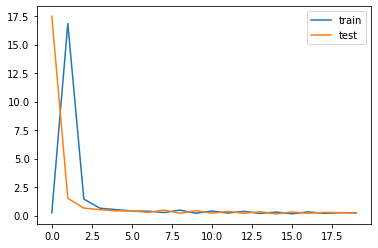

In [36]:
plt.figure
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['train','test'])

Red en acción 

In [48]:
prediction = model.predict(train_imag[:5])   
prediction

array([[0.2661189 , 0.20827554, 0.27646747, 0.17045091],
       [0.6447404 , 0.4625951 , 0.66199213, 0.43968746],
       [0.3510995 , 0.2681619 , 0.36646286, 0.23502421],
       [0.24780782, 0.20018193, 0.2775834 , 0.1801714 ],
       [0.48998815, 0.3514241 , 0.4683983 , 0.31831357]], dtype=float32)

Visualizamos las primeras 10 imagenes con las que se evalua la precición del modelo

15.967134833335876 12.496532499790192 16.588048338890076 10.22705465555191


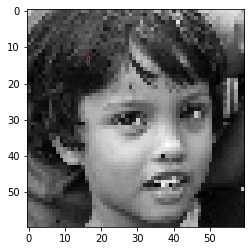

38.68442416191101 27.755706310272217 39.71952795982361 26.381247639656067


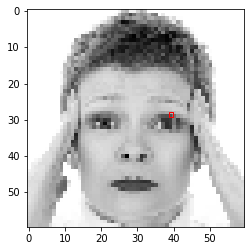

21.065969467163086 16.08971357345581 21.98777139186859 14.101452827453613


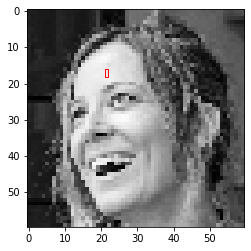

14.868468940258026 12.010915875434875 16.655003428459167 10.81028401851654


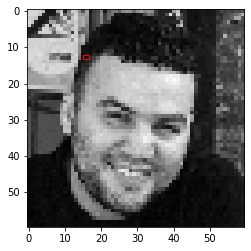

29.39928889274597 21.085445880889893 28.10389816761017 19.098814129829407


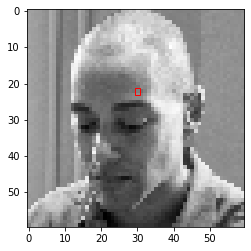

In [47]:
for m in range(5):
    image=Image.open(train_imag_paths[m])   # abrimoslaimagen a travez del path 
    gray_image=image.convert('L')    # loconvertimosa escala de grises 
    gray_image_array=np.asarray(gray_image)   # imagen a tipo array
    #gray_image_array = gray_image_array.astype('float32')/255  # normalizamos   
    gray_image_array = cv2.resize(gray_image_array, (0,0), fx=0.1, fy=0.1)    # cambiamos el tamaño de la imagen 
    fig,ax = plt.subplots(1)
    ax.imshow(gray_image_array,cmap='gray')                                  # mostramos la nueva imagen con su nuevo tamaño 
    #plt.imshow(newImg,cmap='gray')
    xmin = prediction[m][0]*gray_image_array.shape[1]
    ymin = prediction[m][1]*gray_image_array.shape[1]
    xmax = prediction[m][2]*gray_image_array.shape[1]
    ymax = prediction[m][3]*gray_image_array.shape[1]
    rect = patches.Rectangle((abs(xmin),abs(ymin)),abs(xmax-xmin),abs(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')  # rectangulo de las coordenadas 
    ax.add_patch(rect)
    print(xmin,ymin,xmax,ymax)
    plt.show()
